# Homework 1
## Ilia Kamyshev
Skoltech 2021

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Objective function to minimize
def function(x, y):
    function.oracle_calls += 1
    return (
        np.sin(y) * np.exp((1 - np.cos(x)) ** 2)
        + np.cos(x) * np.exp((1 - np.sin(y)) ** 2)
        + (x - y) ** 2
    )

In [3]:
# Domain boundary
def constrain(point):
    '''
    Makes a projection of a point (which is outside the boundary) 
    on the boundary
    '''
    x, y = point
    if (x + 5) ** 2 + (y + 5) ** 2 >= 25:
        angle = np.arctan2(y + 5, x + 5)
        x = -5 + 5 * np.cos(angle)
        y = -5 + 5 * np.sin(angle)
    return np.array([x, y])


def make_simplex(start, scale, dim=2):
    '''
    Makes coordinates of an initial regular simplex
    '''
    assert (start[0] + 5) ** 2 + (start[1] + 5) ** 2 < 25, "x0 is out of boundary"

    # Parameters from the paper
    p = 1 / (dim * np.sqrt(2)) * (dim - 1 + np.sqrt(dim + 1))
    q = 1 / (dim * np.sqrt(2)) * (np.sqrt(dim + 1) - 1)
    
    # Memory allocation and starting point assignment
    simplex = np.zeros((dim + 1, dim), dtype=np.float32)
    simplex[0] = start
    
    for i in range(1, dim + 1):
        for j in range(dim):
            if j == i - 1:
                simplex[i][j] = start[j] + scale * p
            elif j != i - 1:
                simplex[i][j] = start[j] + scale * q
        simplex[i] = constrain(simplex[i])
    return simplex


def get_centroid(simplex):
    return constrain(np.mean(simplex[:-1].transpose(), axis=-1))


def sort_simplex(objective, simplex, just_values=False):
    # Compute values of the objective function for each
    # vertex of a simplex
    values = np.inf * np.ones(3)
    for i, v in enumerate(simplex):
        values[i] = objective(*v)
        
    if just_values:
        return None, values
    else:
        # Sort values in ascending order
        sort = np.argsort(values)
        # Sort simplex
        simplex = simplex[sort]
        return simplex, values


def reflection(objective, centroid, worst, r):
    reflectoid = centroid + r * (centroid - worst)
    reflected = objective(*reflectoid)
    return constrain(reflectoid), reflected


def expansion(objective, centroid, reflectoid, e):
    expanoid = centroid + e * (reflectoid - centroid)
    expanded = objective(*expanoid)
    return constrain(expanoid), expanded


def outside_contraction(objective, centroid, reflectoid, c):
    outside_contractoid = centroid + c * (reflectoid - centroid)
    outside_contracted = objective(*outside_contractoid)
    return constrain(outside_contractoid), outside_contracted


def inside_contraction(objective, centroid, worst, c):
    inside_contractoid = centroid - c * (centroid - worst)
    inside_contracted = objective(*inside_contractoid)
    return constrain(inside_contractoid), inside_contracted


def shrink(simplex, s):
    for i in range(1, len(simplex)):
        simplex[i] = constrain(simplex[0] + s * (simplex[i] - simplex[0]))
    return simplex

In [4]:
def optimize(objective, simplex, values, r=1, e=2, c=0.5, s=0.5, constraint=None):
    centroid = get_centroid(simplex[:-1])
    worst = simplex[-1]

    # 1. Reflection
    reflectoid, reflected = reflection(objective, centroid, worst, r)
    if reflected < values[0]:
        # 2. Expansion
        expanoid, expanded = expansion(objective, centroid, reflectoid, e)
        if expanded < reflected:
            simplex[-1] = expanoid
        else:
            simplex[-1] = reflectoid
    elif values[0] <= reflected and reflected < values[1]:
        simplex[-1] = reflectoid
    elif values[1] <= reflected and reflected < values[-1]:
        # 3. Outside contraction
        outside_contractoid, outside_contracted = outside_contraction(
            objective, centroid, reflectoid, c
        )
        if outside_contracted <= reflected:
            simplex[-1] = outside_contractoid
        else:
            # 5. Shrink
            simplex = shrink(simplex, s)
    elif reflected >= values[-1]:
        # 4. Inside contraction
        inside_contractoid, inside_contracted = inside_contraction(
            objective, centroid, worst, c
        )
        if inside_contracted < values[-1]:
            simplex[-1] = inside_contractoid
        else:
            # 5. Shrink
            simplex = shrink(simplex, s)
    return simplex

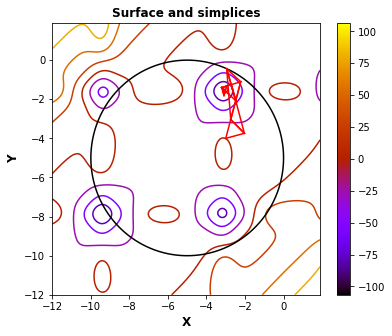

Oracle calls = 125; Minimal value = -106.7645 at point (-3.13, -1.58)


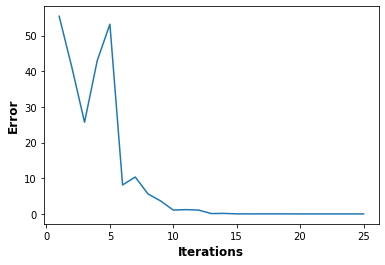

In [5]:
function.oracle_calls = 0

# Visualize contour plot of given surface
x_axis = np.arange(-12, 2, 0.1)
y_axis = np.arange(-12, 2, 0.1)
x_mesh, y_mesh = np.meshgrid(x_axis, y_axis)
surface = function(x_mesh, y_mesh)

# Setup colorbar
mappable = plt.cm.ScalarMappable(cmap=plt.cm.gnuplot)
mappable.set_array(surface)
mappable.set_clim(np.min(surface), -np.min(surface))

# Make plot
fig = plt.figure(figsize=(6, 5))
plt.contour(x_mesh, y_mesh, surface, cmap="gnuplot")
fig.colorbar(mappable)

# Plot domain boundary
plt.contour(
    x_mesh, y_mesh, (x_mesh + 5) ** 2 + (y_mesh + 5) ** 2 - 25, [0], cmap="gray"
)

# Setup initial parameters
function.oracle_calls = 0
tolerance = 1e-4
# start = np.array([-5, -7], dtype=np.float32)  # x0 (starting point)
# start = np.array([-8, -7], dtype=np.float32)  # x0 (starting point)
start = np.array([-3, -4], dtype=np.float32)  # x0 (starting point)
simplex = make_simplex(start, 1)  # Initial simplex
simplex, values = sort_simplex(function, simplex)

# Initial simplex plot
for i in range(len(simplex)):
    plt.plot(
        [simplex[-i][0], simplex[-i + 1][0]],
        [simplex[-i][1], simplex[-i + 1][1]],
        color="red",
    )

errors = [1e5]
while errors[-1] > tolerance:  # Loop until the termination condition
    # Minimization callback
    simplex = optimize(function, simplex, values, r=1, e=2, c=0.5, s=0.5)

    # Check termination
    simplex, values = sort_simplex(function, simplex)
    error = np.abs(np.max(values) - np.min(values))
    errors.append(error)

    # Simplex plot
    for i in range(len(simplex)):
        plt.plot(
            [simplex[-i][0], simplex[-i + 1][0]],
            [simplex[-i][1], simplex[-i + 1][1]],
            color="red",
        )

    # Free memory
    del error

plt.title("Surface and simplices", fontsize=12, fontweight=900)
plt.xlabel("X", fontsize=12, fontweight=900)
plt.ylabel("Y", fontsize=12, fontweight=900)
plt.show()

print(
    "Oracle calls = %d; Minimal value = %.4f at point (%.2f, %.2f)"
    % (function.oracle_calls, np.min(values), *simplex[0])
)

errors.pop(0)  # Drop initial value since that was not produced by the algorithm

# Error plot
plt.plot(list(range(1, len(errors) + 1)), errors)
plt.xlabel("Iterations", fontsize=12, fontweight=900)
plt.ylabel("Error", fontsize=12, fontweight=900)
plt.show()

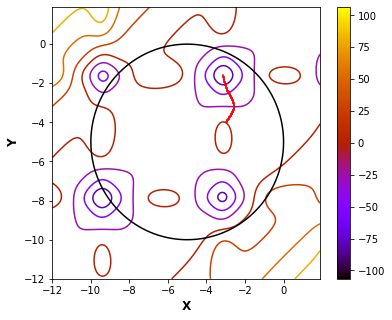

Oracle calls = 169; Minimal value = -106.7645 at point (-3.13, -1.58)


In [6]:
function.oracle_calls = 0
# Visualize contour plot of given surface
x_axis = np.arange(-12, 2, 0.1)
y_axis = np.arange(-12, 2, 0.1)
x_mesh, y_mesh = np.meshgrid(x_axis, y_axis)
surface = function(x_mesh, y_mesh)

# Setup colorbar
mappable = plt.cm.ScalarMappable(cmap=plt.cm.gnuplot)
mappable.set_array(surface)
mappable.set_clim(np.min(surface), -np.min(surface))

# Make plot
fig = plt.figure(figsize=(6, 5))
plt.contour(x_mesh, y_mesh, surface, cmap="gnuplot")
fig.colorbar(mappable)

# Plot domain boundary
plt.contour(
    x_mesh, y_mesh, (x_mesh + 5) ** 2 + (y_mesh + 5) ** 2 - 25, [0], cmap="gray"
)

# Algorithm parameters
gamma = 1e-3 # Learning rate
alpha = 1e-10 # Discretization
tolerance = 1e-4

x = np.array([-3, -4])
error = 1e9

k = 0
function.oracle_calls = 0
while error > tolerance:
    prev = x
    j = k % len(x)
    h = np.array([0, 0])
    h[j] = 1

    s = 0.5 / alpha * (function(*(x + alpha * h)) - function(*(x - alpha * h))) * h
    x = constrain(x - gamma * s)
    plt.plot([prev[0], x[0]], [prev[1], x[1]], color="red")

    error = np.linalg.norm(s, ord=np.inf) 
    k += 1
    
plt.xlabel("X", fontsize=12, fontweight=900)
plt.ylabel("Y", fontsize=12, fontweight=900)
plt.show()
print(
    "Oracle calls = %d; Minimal value = %.4f at point (%.2f, %.2f)"
    % (function.oracle_calls // 2, function(*x), *x)
    # // 2 because it is assumed we already calculated f(prev) and f(x) for 
    # error estimation
)